# Усманова Анастасия, 674 группа

# Задача 3.4

Даны результаты работы двух машинных переводчиков на небольших выборках переводов для разных языковых пар.

Стандартная оценка качества перевода производится с использованием специальной метрики BLEU.

Требуется опеделить:

- превосходит ли один переводчик в среднем по парам второй переводчик по переводу
- связано ли качество перевода для разных языковых пар для двух переводчиков?

При подсчете BLEU учитывать только слова, регистр не учитывать.

Формат данных

Названиие файлов имеет формат lang1_lang2_<translator_id>.txt:

lang_1, lang_2 --- языки (перевод с lang_1 на lang_2).

gold - эталонный вариант, с которым сравнивается перевод от систем машинного перевода.

In [216]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pylab as plt
from nltk.translate import bleu_score
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method1

### 1. Приведем данные к рабочему виду.

In [178]:
pairs = ['de_en' , 'en_kk' , 'en_ru' , 'ru_de' , 'ru_kk']
types = ['_1.txt', '_2.txt', '_gold.txt' ]
path = 'data/mt/'
texts = {i:{} for i in pairs}
for pair in pairs:
    for t in types:
        with open(path + pair + t, 'r', encoding="utf-8") as f:
            #приводим к нижнему регистру
            #разбиваем на предложения
            texts[pair][t] = f.read().lower().split('\n')
            #удалим пустые строки
            texts[pair][t] = [x for x in texts[pair][t] if len(x)>0]

In [179]:
texts['de_en']['_1.txt'][0]

'from 2003 to 2007 he was president of the british film institute.'

In [180]:
#Убедимся, что количество предложений в текстах совпадает.
data_len = pd.DataFrame(columns=['1', '2', 'gold'])
for pair in pairs:
    row = []
    for t in types:
        row.append(len(texts[pair][t]))
    data_len.loc[pair] = row
data_len

,1,2,gold
de_en,100,100,100
en_kk,61,61,61
en_ru,94,94,94
ru_de,50,50,50
ru_kk,90,90,90


### 2. Вычисляем оценки качества переводчиков

In [213]:
def quality(text1, text2):
    score = 0
    for i, sent1 in enumerate(text1):
        sent2 = text2[i]
        score += bleu_score.sentence_bleu(sent1,sent2, smoothing_function=smoothie)
    return score/len(text1)

data = pd.DataFrame(columns=['1', '2'])

In [214]:
for pair in pairs:
    data_row = []
    data_row.append(quality(texts[pair][types[0]], texts[pair][types[2]]))
    data_row.append(quality(texts[pair][types[1]], texts[pair][types[2]]))
    data.loc[pair] = data_row
    
data['1>2'] = data['1']>data['2']
data    

,1,2,1>2
de_en,0.006103,0.006008,True
en_kk,0.011882,0.011845,True
en_ru,0.012175,0.015287,False
ru_de,0.005207,0.005221,False
ru_kk,0.008805,0.009498,False


Мы видим, что 2ой переводчик превзошел 1ый в трех случаях из пяти.
Следовательно, качество перевода зависит от языковой пары. 

### 3. Формальная постановка задачи 1

- $H_0:$ средние значения качества переводчиков равны $P(Quality1>Quality2)=1/2$
- $H_1:$ средние значение качества переводчиков не равны
$P(Quality1>Quality2)< \ne >1/2$

### 4. Проверка нулевой гипотезы

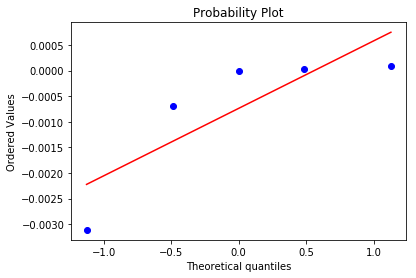

In [218]:
_=st.probplot(data['1'] - data['2'], plot=plt)

In [219]:
st.shapiro(data['1'] - data['2'])

(0.714332640171051, 0.013444613665342331)

Видим, что данные не распределены нормально. Поэтому используем непараметрические критерии. 

In [220]:
#Критерий знаков
from statsmodels.stats.descriptivestats import sign_test
sign_test(data['1'] - data['2'])

(-0.5, 1.0)

In [221]:
#Уилкоксон
st.wilcoxon(data['1'] - data['2'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


WilcoxonResult(statistic=5.0, pvalue=0.5001842570707944)

In [223]:
#Перестановочный критерий
from permute.core import one_sample
one_sample(data['1'], data['2'],  alternative='two-sided')

(0.37313626863731364, -0.0007372653318128643)

Данные гипотезе не противоречат. Поэтому мы не можем сказать, что один переводчик лучше другого. 

### 5. Итог
Нельзя определить, какой из переводчиков лучше. И мы видим, что качество перевода зависит от языковой пары.